# Install and Set Up Kaggle and API Key

Follow these steps to install and configure the Kaggle API on your system:

1. **Create a Kaggle Account**
   - Visit [Kaggle](https://www.kaggle.com) and sign up for an account.

2. **Obtain Kaggle API Key**
   - Go to your Kaggle account settings.
   - Find the "API" section and click on "Create New API Token".
   - This will download a `kaggle.json` file containing your API key.

3. **Install Kaggle Package**
   - Use Conda to install the Kaggle package by running:
     ```bash
     conda install kaggle
     ```

4. **Configure API Key**
   - Copy the `kaggle.json` file to your user directory under the `.kaggle` folder. On most systems, you can use the following command:
     ```bash
     mkdir -p ~/.kaggle
     cp path_to_downloaded_kaggle.json ~/.kaggle/kaggle.json
     chmod 600 ~/.kaggle/kaggle.json
     ```
   - Ensure the `.kaggle` directory and the `kaggle.json` file have the proper permissions by setting:
     ```bash
     chmod 600 ~/.kaggle/kaggle.json
     ```


In [1]:
import pandas as pd
import kaggle
import Marketing_Campaign as mc
# Pre processing
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
import numpy as np


# Scoring 
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE



# models 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
#plotting
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.pipeline import make_pipeline as make_imbalance_pipeline

from statsmodels.stats.outliers_influence import variance_inflation_factor


# import Dataset

In [2]:
# Get the data using an API call
kaggle.api.dataset_download_files('rodsaldanha/arketing-campaign', path='resources', unzip=True)

Dataset URL: https://www.kaggle.com/datasets/rodsaldanha/arketing-campaign


In [3]:
# Import the data
data = pd.read_csv("./resources/marketing_campaign.csv",delimiter=';')


# EDA (Exploratory Data Analysis)
We will revisit this. For now We want the rough draft of the model
#
During EDA

Visualize the data using plots and graphs to understand distributions and relationships between variables.
Calculate summary statistics to get a sense of the central tendencies and variability.
Identify any correlations between variables that might influence model choices.
Detect and treat missing values or outliers that could skew the results of your analysis.
Explore the data's structure to inform feature selection and engineering, which are key to building effective machine learning models.

# Read any and all documentation you can find on your dataset to understand it better


In [4]:
display (data.head())
# what does our data look like? At this point also use any documentation on the data set to find out what each value means and how it might be used is solving the business problem
print (f'{data.shape}\n')

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,5,0,0,0,0,0,0,3,11,0


(2240, 29)



In [5]:
# Preprocess = Clean up NA if number of NA in column is less that a percentage of rows
# this automatically cleans up rows below a threshold and list columns when NA rows exceed the threshold
data1=mc.auto_drop_na(data,2)

Drop Percent of the rows is %2
If the number of NA values in a column is less than the calculated threshold, automatically drop the NA rows.
{'Income': 24}
Automatically dropping rows in Income where NA values are present.


In [6]:
# Identify non numeric columns we will need to deal with
non_numeric= (data1.dtypes[(data1.dtypes != 'int64') & (data1.dtypes != 'float64')]).index.tolist()
# display (data.dtypes)
print (f'Columns that are not numeric :\n {non_numeric}\n')

for column in non_numeric:
    print (data1[column].value_counts())
    print ('\n')

Columns that are not numeric :
 ['Education', 'Marital_Status', 'Dt_Customer']

Education
Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: count, dtype: int64


Marital_Status
Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: count, dtype: int64


Dt_Customer
2012-08-31    12
2012-09-12    11
2013-02-14    11
2014-05-12    11
2013-08-20    10
              ..
2012-08-05     1
2012-11-18     1
2014-05-09     1
2013-06-26     1
2014-01-09     1
Name: count, Length: 662, dtype: int64




# Numeric data to group
The year of birth data creates too many unique data to be useful. We have chosen to convert the Year Birth data to a 6 generation values. After one hot encode for generation we drop the year birth column. 

# non numeric column 
- Education OrdinalEncoder because education counts
     - 0 - **Basic** This generally refers to elementary or primary education.
     - 1 - **2n Cycle** This is not a commonly used term globally but might refer to secondary education or an intermediary level in some education systems.
     - 2 - **Graduation** Typically refers to the completion of a bachelor's or undergraduate degree.
     - 3 - **Master** A postgraduate degree that follows the completion of a bachelor's degree.
     - 4 - **PhD** The highest university degree, typically following a master's degree.

- Marital_Status - The status has no weighted values. change none standard answers to single and then one hot encode three remaining values
     - Alone     Single
     - Absurd    Single
     - YOLO      Single

- Year_Birth - Convert to 6 generations and then One Hot Encode

- Dt_Customer - We will convert to data time and represent this in number of months the cusomter has been with us

# ID column
The id column is etiher a uniwue customer id or an index falue that became a column in the past

In [7]:
# Education encode
categories = ['Basic','2n Cycle','Graduation','Master','PhD']
column = 'Education'
data2 = mc.preprocess_ord(data1,column,categories)

# One Hot ENncode
We want to One Hot Encode Marital Status and Generations.
This takes some preperation
-- Marital needs to change Alone, Absurd and YOLO to Single. 
-- Year_Birth needs to be encoded as generations first

In [8]:
# Marital Status Encode
data2['Marital_Status'] = data2['Marital_Status'].replace(['Alone', 'Absurd', 'YOLO'], 'Single')


In [9]:
# transform Year_Birth to Generations
data3 = mc.set_gen(data2,'Year_Birth')

In [10]:
data4 = mc.date_to_months(data3,'Dt_Customer',2024)

In [11]:
ohe_column_list = ['Marital_Status', 'Generations']
data5 = mc.preprocess_ohe(data4,ohe_column_list)

In [12]:
# Identify columns with only one unique value
single_value_columns = data5.nunique() == 1
# Drop these columns from the DataFrame
data5 = data5.loc[:, ~single_value_columns]
data6 = data5.drop(['ID','Year_Birth'],axis=1)


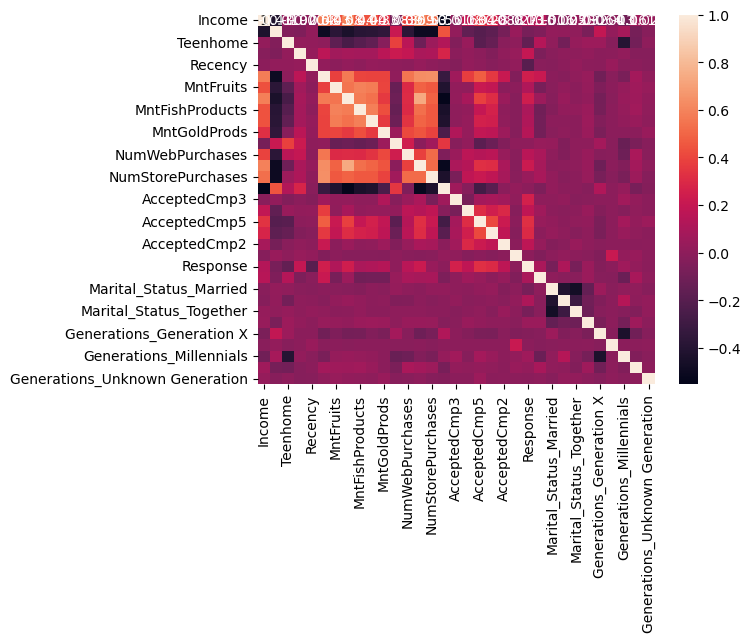

In [13]:
# Correlation matrix
corr_matrix = data6.corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()


In [14]:
correlations = data6.corr() 


# Check correlations with the target variable
target_correlation = correlations['Response'].sort_values()

# Display correlations
print(target_correlation)

# Look for any feature with a perfect correlation
perfect_correlations = target_correlation[(target_correlation == 1) | (target_correlation == -1)]
print("Features perfectly correlated with Y:", perfect_correlations)

Recency                          -0.199766
Teenhome                         -0.153901
Marital_Status_Married           -0.079821
Kidhome                          -0.077909
Marital_Status_Together          -0.075293
Generations_Generation X         -0.036497
Generations_Unknown Generation   -0.012639
Generations_Lost Generation      -0.008935
NumWebVisitsMonth                -0.002209
Complain                         -0.002029
NumDealsPurchases                 0.003451
Generations_Silent Generation     0.019236
NumStorePurchases                 0.036241
Marital_Status_Widow              0.045656
Generations_Millennials           0.063313
Education                         0.099150
MntFishProducts                   0.108145
Marital_Status_Single             0.114126
MntSweetProducts                  0.116170
MntFruits                         0.122443
Income                            0.133047
MntGoldProds                      0.140332
NumWebPurchases                   0.151431
AcceptedCmp

# this section will address the data imbalance we see in our y value. 


In [15]:
print (data6.head())
print (data6.columns)
y = data6['Response']
# Checking the distribution of classes
class_distribution = y.value_counts()
print(class_distribution)
# Getting the percentage distribution of the classes
class_percentage = y.value_counts(normalize=True) * 100
print(class_percentage)

    Income  Kidhome  Teenhome  Dt_Customer  Recency  MntWines  MntFruits  \
0  58138.0        0         0          136       58       635         88   
1  46344.0        1         1          118       38        11          1   
2  71613.0        0         0          125       26       426         49   
3  26646.0        1         0          119       26        11          4   
4  58293.0        1         0          120       94       173         43   

   MntMeatProducts  MntFishProducts  MntSweetProducts  ...  Education  \
0              546              172                88  ...        2.0   
1                6                2                 1  ...        2.0   
2              127              111                21  ...        2.0   
3               20               10                 3  ...        2.0   
4              118               46                27  ...        4.0   

   Marital_Status_Married  Marital_Status_Single  Marital_Status_Together  \
0                     0.0  

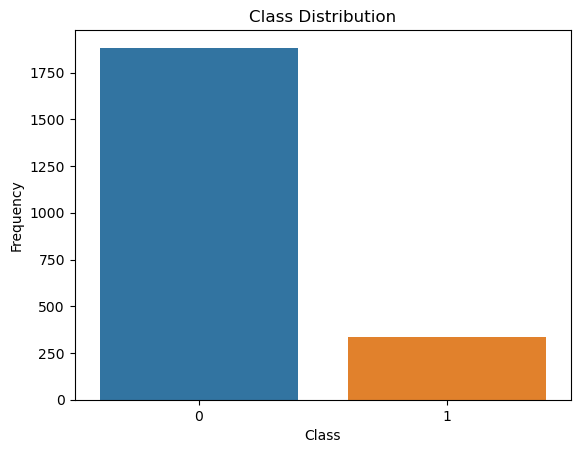

In [16]:
# Plotting the distribution of classes
sns.countplot(x=data6['Response'])
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

In [17]:
X=data6.drop(['Response'],axis=1)
y=data6['Response']

# life is balance in the fast lane

Using 

classification report for
- dataset with no changes
- dataset with underfit RandomUnderSampler
- dataset with overfit RandomOverSampler
- dataset with smote SMOTE
- dataset with smoteenn SMOTEENN

Scalers
- StandardScaler
- MinMaxScaler

Model
- RANDOM FOREST MODEL
- GradientBoostingClassifier
- KNeighborsClassifier
- SVM (Support Vector Machine)
- LogisticRegression
- Decision Tree Model


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# List of classifiers
classifiers = [
    ('RFC', RandomForestClassifier(random_state=42)),
    ('GBC', GradientBoostingClassifier(random_state=42)),
    ('KNN', KNeighborsClassifier()),
    ('SVC', SVC(random_state=42)),
    ('LR', LogisticRegression(max_iter=10000)),
    ('DTC', DecisionTreeClassifier(random_state=42))
]

# List of scalers
scalers = [
    ('SS', StandardScaler()),
    ('MMS', MinMaxScaler())
]

# List of resampling methods
samplers = [
    ('RUS', RandomUnderSampler(random_state=42)),
    ('ROS', RandomOverSampler(random_state=42)),
    ('SMOTE', SMOTE(random_state=42)),
    ('SMOTEENN', SMOTEENN(random_state=42))
]

# Evaluating each combination of sampler, scaler, and classifier
results = []
for sampler_name, sampler in samplers:
    for scaler_name, scaler in scalers:
        for classifier_name, classifier in classifiers:
            pipeline = make_imbalance_pipeline(sampler, scaler, classifier)
            cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
            scores = cross_val_score(pipeline, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
            results.append((sampler_name, scaler_name, classifier_name, scores.mean()))

# Convert results to DataFrame for easy viewing
results_df = pd.DataFrame(results, columns=['Sampler', 'Scaler', 'Classifier', 'Accuracy'])
sorted_results_df = results_df.sort_values(by='Accuracy', ascending=False)
print (f'The top 5 models by are:\n')
print(sorted_results_df.head().to_string(index=False))



The top 5 models by are:

Sampler Scaler Classifier  Accuracy
    ROS    MMS        RFC  0.883557
    ROS     SS        RFC  0.883368
  SMOTE    MMS        GBC  0.882440
  SMOTE     SS        GBC  0.882440
  SMOTE     SS        RFC  0.874525


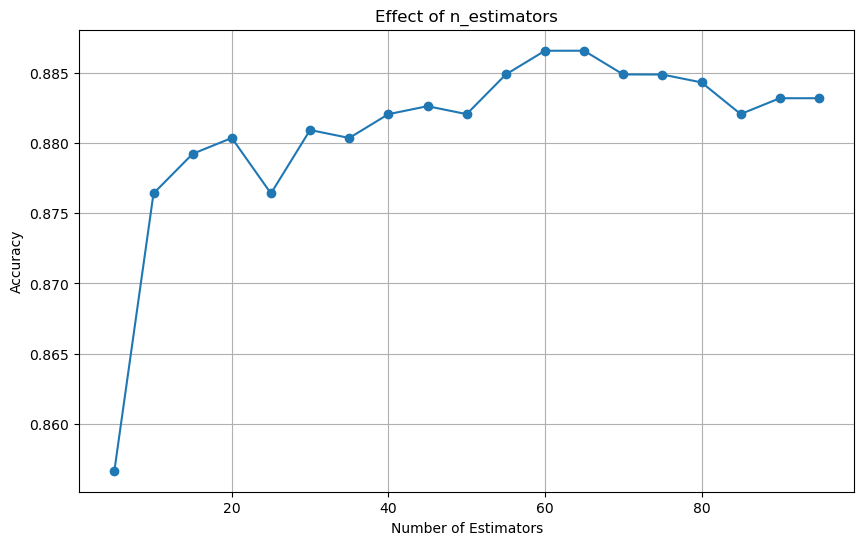

In [19]:
# Using the top model by accuracy score fid the best n_estimator
scores = []
estimators_range = range(5, 100, 5)  # From 10 to 300 in steps of 20

for n in estimators_range:
    model = RandomForestClassifier(n_estimators=n, random_state=42)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')  # 5-fold cross-validation
    scores.append(np.mean(score))

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(estimators_range, scores, marker='o')
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.title('Effect of n_estimators')
plt.grid(True)
plt.show()

# N_estimator
Using Cross Val Score We found that an N_estimator value of 60 would optimize our Random Forest Classifier

In [22]:
#  Identify features with less that 1% importance and drop them
#  
model = RandomForestClassifier(n_estimators=60,random_state=42)
model.fit(X_train, y_train)

# Get feature importances and create a mask for dropping features
importances = model.feature_importances_
features_to_drop = importances < 0.01

# Drop features from DataFrame
X_reduced = X_train.loc[:, ~features_to_drop]

print(f"Original number of features: {X_train.shape[1]}")
print(f"Reduced number of features: {X_reduced.shape[1]}")
X_train=X_reduced

Original number of features: 32
Reduced number of features: 21


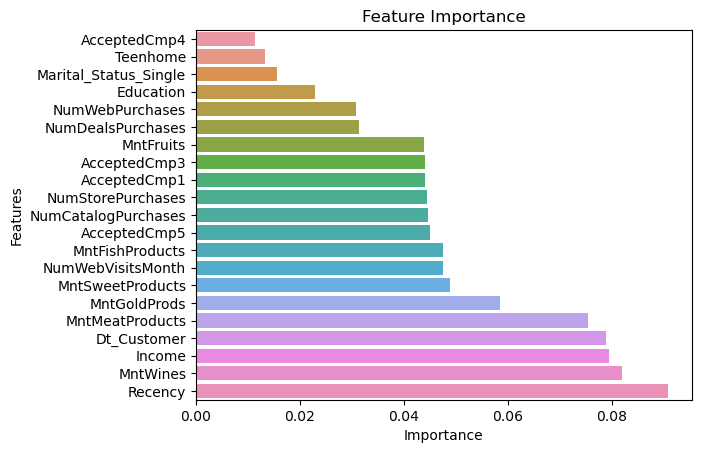

In [23]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
importances = model.feature_importances_

# Create a Series for easier plotting
feature_importance = pd.Series(importances, index=X_train.columns)

# Sorting importances
sorted_importances = feature_importance.sort_values()

# Creating a bar plot
sns.barplot(x=sorted_importances, y=sorted_importances.index)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

In [27]:
# Step 1: Split the original data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Step 2: Address imbalance with RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)


# Step 3: Scale the data (after resampling)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)  # Fit and transform training data
X_test_scaled = scaler.transform(X_test)  # Transform test data based on training scaler

# Step 4: Train and evaluate the model
model = RandomForestClassifier(n_estimators=75,random_state=42)
model.fit(X_train_scaled, y_train_resampled)  # Use the scaled and resampled training data
y_pred = model.predict(X_test_scaled)  # Predict using the scaled test data
print(classification_report(y_test, y_pred))

print (y_pred)


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- AcceptedCmp2
- Complain
- Generations_Generation X
- Generations_Lost Generation
- Generations_Millennials
- ...


In [24]:

X['Intercept'] = 1  

vif_data_df = pd.DataFrame()
vif_data_df["Feature"] = X.columns
vif_data_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
sorted_vif_data_df = vif_data_df.sort_values(by='VIF', ascending=False)
print(sorted_vif_data_df)


# Calculate VIF for each variable
# vif_data_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
# vif_data_df["Variable"] = X.columns

# Reviewing high VIF values
# print(vif_data_df[vif_data_df['VIF'] == float('inf')])


                  Feature         VIF
21              Intercept  436.670801
4                MntWines    3.388654
12    NumCatalogPurchases    3.104647
6         MntMeatProducts    3.094426
14      NumWebVisitsMonth    2.558384
13      NumStorePurchases    2.418137
7         MntFishProducts    2.128517
0                  Income    2.025100
5               MntFruits    1.995245
8        MntSweetProducts    1.957029
11        NumWebPurchases    1.909355
17           AcceptedCmp5    1.642731
9            MntGoldProds    1.528597
10      NumDealsPurchases    1.500898
1                Teenhome    1.422541
18           AcceptedCmp1    1.339298
2             Dt_Customer    1.326811
16           AcceptedCmp4    1.305345
19              Education    1.174459
15           AcceptedCmp3    1.103913
20  Marital_Status_Single    1.021381
3                 Recency    1.008157


In [ ]:
# Select only numeric columns for VIF calculation
X = data6.select_dtypes(include=[np.number])  

# It's common practice to add an intercept for regression models, but for VIF calculation
# it's typically not necessary unless you're explicitly modeling the intercept
# X['Intercept'] = 1  

# Initialize DataFrame to store VIF values
vif_data_df = pd.DataFrame()
vif_data_df["Feature"] = X.columns  # Assign column names first

# Calculate VIF for each variable and store in DataFrame
vif_data_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Sort the DataFrame by VIF values in descending order
sorted_vif_data_df = vif_data_df.sort_values(by='VIF', ascending=False)

# Print the sorted VIF values
print(sorted_vif_data_df)

# Optional: Print DataFrame to check data (unrelated to VIF calculation)
print(data6.head())

In [ ]:
model = RandomForestClassifier()
model.fit(X, y)  # Ensure X and y are your feature matrix and target vector respectively
importance = model.feature_importances_

# Correct printing method
for i, v in enumerate(importance):
    print('Feature: %d, Score: %.5f' % (i, v))